## Lab: Graph theory

In this lab you will be introduced to graph theory using NetworkX.  For this lab we will focus on *undirected* graphs -- that is, graphs where the edges don't have a direction.  Later in the course we will encounter *directed* graphs, where the edges are arrows that have a direction.

### Setup


In [1]:
import os,sys
from Bio import Entrez
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy
import pandas
import random
import pickle 
import scipy.stats

%matplotlib inline

# fix random seeds to exactly replicate simulations
numpy.random.seed(42)
random.seed(42)

### Example 1: A simple graph

Let's create a graph representing the publication network between a number of neuroscientists.  

Each node in the graph will represent one of the individuals.  First we need to generate the graph object, and then add the nodes.

In [2]:
researchers={'OS':{'name':'Olaf Sporns'},
            'DB':{'name':'Danielle Bassett'},
            'AF':{'name':'Alex Fornito'},
            'MB':{'name':'Michael Breakspear'},
            'LU':{'name':'Lucina Uddin'},
            'MM':{'name':'Mike Milham'},
            'CC':{'name':'Cameron Craddock'}}

G = nx.Graph()

G.add_nodes_from(researchers.keys())

We can see the nodes using the nodes element in the graph object:

In [3]:
G.nodes

NodeView(('OS', 'DB', 'AF', 'MB', 'LU', 'MM', 'CC'))

Each node in the graph can have attributes associated with it, which we can add to the nodes as we would add a dictionary element:

In [4]:
for researcher in researchers:
    G.nodes[researcher]['name']=researchers[researcher]['name']
    print(researcher,G.nodes[researcher])

OS {'name': 'Olaf Sporns'}
DB {'name': 'Danielle Bassett'}
AF {'name': 'Alex Fornito'}
MB {'name': 'Michael Breakspear'}
LU {'name': 'Lucina Uddin'}
MM {'name': 'Mike Milham'}
CC {'name': 'Cameron Craddock'}


Let's visualize the graph so far using Networkx's visualization tools

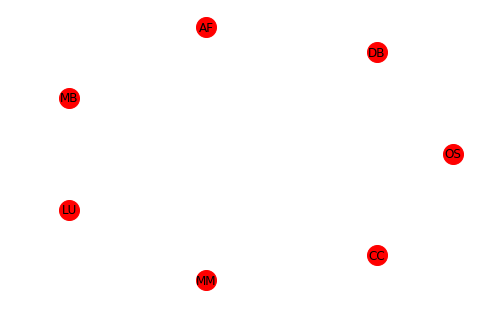

In [5]:
nx.draw_circular(G,with_labels=True,node_size=400)


So far we have a completely disconnected graph - that is, it has no edges (i.e. connections).  Now let's add edges based on the publication history.  First we will generate a matrix containing the number of joint publications between each of the researchers (whcih in this case are made up). 

In [6]:
# first get pubmed search terms from names
for i in researchers:
    n_s=researchers[i]['name'].lower().split(' ')
    researchers[i]['pubmed_name']=n_s[1]+'-'+n_s[0][0]

# get number of joint pubs for each pair
def get_joint_pubs(author_pair, email,retmax=200000,):
    """
    get all pubs for two authors
    author_pair: tuple containing two pubmed search terms
    email: email address for use by Entrez
    """
    Entrez.email=email # enter your email address here
    assert len(author_pair)==2
    search_term='%s AND %s'%(author_pair[0],author_pair[1])
    handle = Entrez.esearch(db="pubmed", retmax=retmax,term=search_term)
    record = Entrez.read(handle)
    handle.close()
    pmids=list(set([int(i) for i in record['IdList']]))
    return(len(pmids))


numpubs={}
email='bill@gmail.com'  # email address for use by Entrez
for i in itertools.combinations(list(researchers.keys()),2):
    numpubs[i]=get_joint_pubs((researchers[i[0]]['pubmed_name'],
                                   researchers[i[1]]['pubmed_name']),
                                   email)
numpubs

{('OS', 'DB'): 1,
 ('OS', 'AF'): 0,
 ('OS', 'MB'): 6,
 ('OS', 'LU'): 0,
 ('OS', 'MM'): 2,
 ('OS', 'CC'): 0,
 ('DB', 'AF'): 2,
 ('DB', 'MB'): 1,
 ('DB', 'LU'): 0,
 ('DB', 'MM'): 1,
 ('DB', 'CC'): 0,
 ('AF', 'MB'): 4,
 ('AF', 'LU'): 0,
 ('AF', 'MM'): 0,
 ('AF', 'CC'): 0,
 ('MB', 'LU'): 0,
 ('MB', 'MM'): 0,
 ('MB', 'CC'): 0,
 ('LU', 'MM'): 18,
 ('LU', 'CC'): 0,
 ('MM', 'CC'): 2}

In [7]:
# create a list to use in making the matrix
# do this so that the order stays fixed
researchers_list=list(researchers.keys()) 

# create a data frame to hold all of the entries
# for each combination of researchers

df=pandas.DataFrame(numpy.zeros((len(researchers),
                                 len(researchers))),
                   index=researchers_list,
                   columns=researchers_list)

# we just fill in the upper triangle of the matrix
for i,j in enumerate(researchers_list):
    for k in range(i,len(researchers_list)):
        if i==k:
            continue
        df.loc[j][k]=get_joint_pubs((researchers[j]['pubmed_name'],
                                   researchers[researchers_list[k]]['pubmed_name']),
                                   email)

print(df)


     OS   DB   AF   MB   LU    MM   CC
OS  0.0  1.0  0.0  6.0  0.0   2.0  0.0
DB  0.0  0.0  2.0  1.0  0.0   1.0  0.0
AF  0.0  0.0  0.0  4.0  0.0   0.0  0.0
MB  0.0  0.0  0.0  0.0  0.0   0.0  0.0
LU  0.0  0.0  0.0  0.0  0.0  18.0  0.0
MM  0.0  0.0  0.0  0.0  0.0   0.0  2.0
CC  0.0  0.0  0.0  0.0  0.0   0.0  0.0


Now let's use the co-publication matrix to generate a binary adjacency matrix, which will represent whether there is a link between each pair of investigators.  This is obtained by thresholding the co-publication matrix; for now we will just threshold at greater than zero, so that any publications are sufficient to create an edge.

In [8]:
threshold=0
adjacency_mtx=(df>threshold).astype('int')
print(adjacency_mtx)

    OS  DB  AF  MB  LU  MM  CC
OS   0   1   0   1   0   1   0
DB   0   0   1   1   0   1   0
AF   0   0   0   1   0   0   0
MB   0   0   0   0   0   0   0
LU   0   0   0   0   0   1   0
MM   0   0   0   0   0   0   1
CC   0   0   0   0   0   0   0


Now let's use the adjacency matrix to determine which pairs have an edge, and then add those to the graph.

In [9]:
matches=numpy.where(adjacency_mtx>0)
for i in range(len(matches[0])):
    G.add_edge(researchers_list[matches[0][i]],
               researchers_list[matches[1][i]])

Now we can see the edges as part of the graph object:

In [10]:
G.edges

EdgeView([('OS', 'DB'), ('OS', 'MB'), ('OS', 'MM'), ('DB', 'AF'), ('DB', 'MB'), ('DB', 'MM'), ('AF', 'MB'), ('LU', 'MM'), ('MM', 'CC')])

And we can now visualize the graph with the edges included.

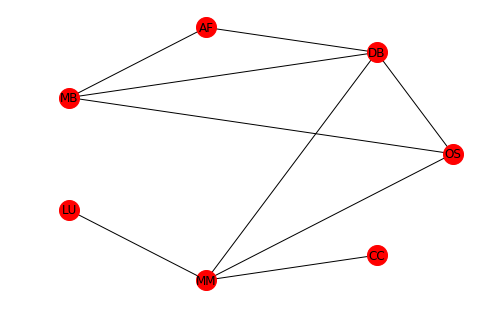

In [11]:
nx.draw_circular(G,with_labels=True,node_size=400)


The circular graph is not very useful because it's hard to see the structure of the network.  Instead let's draw it using a spring embedding algorithm, which treats each edge as a spring and tries to minimize the force exerted on all of the springs taken together. 

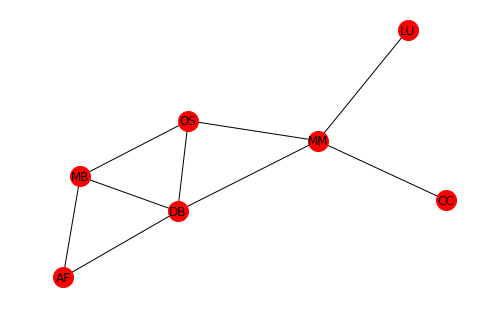

In [12]:
nx.draw_spring(G,with_labels=True,node_size=400)


### Node characteristics

Now that the graph is generated, we can examine the characteristics of some of the nodes.  First, let's look at the number of edges for each node - that is, its *degree*. This is stored in the degree element within the graph object.

In [13]:
G.degree

DegreeView({'OS': 3, 'DB': 4, 'AF': 2, 'MB': 3, 'LU': 1, 'MM': 4, 'CC': 1})

We could also compute the degree by summing the adjacency matrix.  We first need to make it a symmetric matrix (since above we only included the upper triangle of the matrix) - we can do that by adding its transpose to the original matrix, and then summing across rows to get the degree.

In [14]:
adjacency_mtx_symm=adjacency_mtx+adjacency_mtx.T
adjacency_mtx_symm['degree']=adjacency_mtx_symm.sum(1)
print(adjacency_mtx_symm)

    OS  DB  AF  MB  LU  MM  CC  degree
OS   0   1   0   1   0   1   0       3
DB   1   0   1   1   0   1   0       4
AF   0   1   0   1   0   0   0       2
MB   1   1   1   0   0   0   0       3
LU   0   0   0   0   0   1   0       1
MM   1   1   0   0   1   0   1       4
CC   0   0   0   0   0   1   0       1


It's also common to present the adjacency matrix as an image, with the color scale (usually black/white) denoting the presence/absence of connections. Note that by default we set the diagonal (i.e. self-connections) to zero.

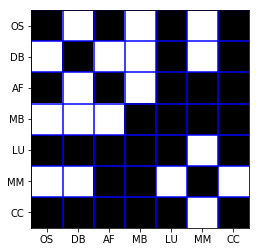

In [15]:
plt.imshow(adjacency_mtx+adjacency_mtx.T,cmap='gray')

# set the axes to use name labels rather than numbers
ax=plt.gca()
ax.set_yticks(numpy.arange(len(researchers_list)))
ax.set_xticks(numpy.arange(len(researchers_list)))
ax.set_xticklabels(researchers_list)
ax.set_yticklabels(researchers_list)
# add grid lines
for i in range(len(researchers_list)):
    ax.axvline(x=i-0.5,color='b')
    ax.axhline(y=i-0.5,color='b')

### Example 2: A more complex network

The example above was nice to get started, but usually we work with much larger networks.  For a more realistic example, let's look at some Facebook friendship data from the Stanford Large Network Database: https://snap.stanford.edu/data/egonets-Facebook.html

In [16]:
facebook_data=pandas.read_csv('data/facebook_combined.txt',sep=' ',
                             header=None)
# generate a networkx graph
G_facebook=nx.Graph()
for i in facebook_data.index:
    G_facebook.add_edges_from([tuple(facebook_data.loc[i])])



Let's visualize this network using a spring-embedded graph as we used above.

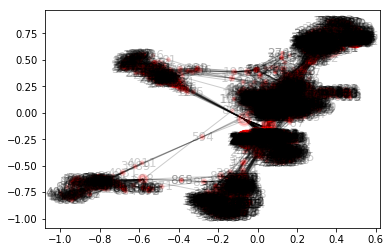

In [17]:
d = nx.degree(G_facebook)
fb_spring_layout=nx.spring_layout(G_facebook)

nx.draw_networkx(G_facebook,fb_spring_layout,
               nodelist=dict(d).keys(), 
               node_size=[v for v in dict(d).values()],
               linewidths=3,
               alpha=0.2)

This does a much better job of showing the structure of the network. In particular, we can see that there are groups of individuals clustered together. We will examine this further in later exercises.


### Degree distributions

The degree distribution of a network can provide a glimpse into its structure, especially for large networks. Let's plot a histogram the degree distribution for this dataset.

mean degree: 43.69101262688784
max degree: 1045


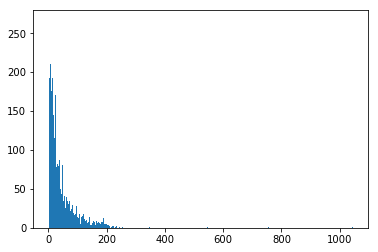

In [18]:
degree_vals = [G_facebook.degree[i] for i in G_facebook.nodes]
degree_dist = plt.hist(degree_vals,500)
print('mean degree:',numpy.mean(degree_vals))
print('max degree:',numpy.max(degree_vals))


This is a very long-tailed distribution - the highest degree is more than 20 times the mean!  This kind of degree distribution is commonly seen in complex networks.  Often these are characterized by a power law relationship between degree and frequency (though this is tricky to establish - see Clauset et al., 2008).  A power law is linear in log coordinates, so we can plot the data in log-log coordinates to see this:

/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


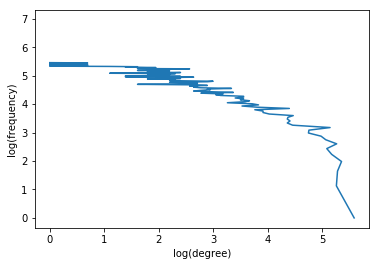

In [19]:
binsize=degree_dist[1][1]-degree_dist[1][0]
plt.plot(numpy.log(degree_dist[0]),numpy.log(degree_dist[1][1:]-binsize))
plt.xlabel('log(degree)')
plt.ylabel('log(frequency)')

This looks fairly linear until it gets to the tail, where it drops off faster than expected. This is indicative of a truncated power law, which is also commonly seen in real-world complex networks.

What would we expect the degree distribution to look like if the network was randomly connected? Let's write a simulation to generate a network with the same mean degree and number of nodes, but with random connections.

In [20]:
def mk_random_graph(G_init,verbose=False,maxiter=5):
    # need to divide the number of edges by two since 
    edgelist=numpy.random.randint(len(G_init.nodes),
                                  size=(len(G_init.edges),2))
    good_list=False
    iter=0
    while not good_list:
        if iter>maxiter:
            print('hit maxiter')
            return None
        if verbose:
            print(len(edgelist))
        edgelist=edgelist[edgelist[:,0]!=edgelist[:,1]]
        if verbose:
            print('self-edge removal',len(edgelist))
        edgelist=numpy.sort(edgelist,axis=1)
        edgelist=numpy.unique(edgelist,axis=0)
        if verbose:
            print('duplicate removal',len(edgelist))
        if len(edgelist)==len(G_init.edges):
            good_list=True
        else:
            iter+=1
            edgelist=numpy.vstack((edgelist,
                        numpy.random.randint(len(G_init.nodes),
                                size=(len(G_init.edges)-len(edgelist),2)) ))
    G_rand=nx.Graph()
    for i in range(edgelist.shape[0]):
        G_rand.add_edge(edgelist[i,0],edgelist[i,1])
        
    return(G_rand)

Now let's run the simulation to generate a random network and look at its degree distribution.

random graph:
mean degree: 43.69101262688784
max degree: 68


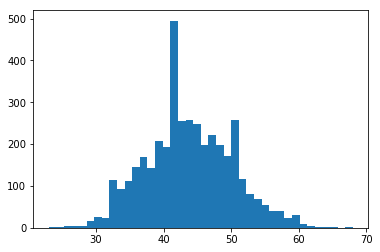

In [21]:
G_rand=mk_random_graph(G_facebook)
degree_vals_rand = [G_rand.degree[i] for i in G_rand.nodes]
degree_dist_rand = plt.hist(degree_vals_rand,40)
print('random graph:')
print('mean degree:',numpy.mean(degree_vals_rand))
print('max degree:',numpy.max(degree_vals_rand))


Let's also visualize the data to see what a randomly connected network looks like.

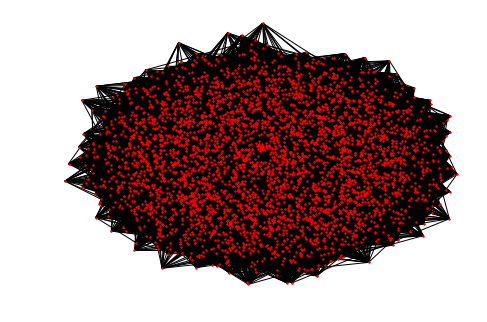

In [22]:
nx.draw_spring(G_rand,node_size=2)

### Clustering

One of the interesting features of real-world networks is that nodes are often clustered together, which we saw graphically in the Facebook data displayed above.  Within graph theory, we can quantify the clustering of a network using the [clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient), which quantifies the number of closed triangles (i.e. sets of three nodes in which all three are connected) compared to the number of total triangles (i.e. sets of three nodes with either two or three edges).  Let's compute this on the Facebook data as well as the random graph that we generated above.

In [23]:
print('Facebook graph:',nx.average_clustering(G_facebook))
print('random graph:',nx.average_clustering(G_rand))

Facebook graph: 0.6055467186200876
random graph: 0.010961334317898672


As expected, the social network graph is highly clustered compared to a random graph.

### Traversing a network

Many people are familiar with the idea of "Six degrees of separation", which arose intially from a famous demonstration by Stanley Milgram.  A real-life example can be found at the [Oracle of Bacon](https://oracleofbacon.org/). When put into the language of graph theory, the idea of "separation" is defined in terms of a set of edges that define a path through the graph.  

There are algorithms that let us determine the shortest path between two nodes in a network.  For example, let's take two random individuals from the Facebook graph and compute the shortest path:

In [24]:
test_nodes=random.sample(list(G_facebook.nodes),2)
print('shortest path between %d and %d'%(test_nodes[0],test_nodes[1]))
print(nx.shortest_path(G_facebook,
                      source=test_nodes[0],
                      target=test_nodes[1]))

print('Length of shortest path:',nx.shortest_path_length(G_facebook,
                      source=test_nodes[0],
                      target=test_nodes[1]))

shortest path between 3078 and 970
[3078, 1684, 107, 970]
Length of shortest path: 3


One interesting feature of a graph is the average path length between each pair of nodes, which tells us how easy it is on average for nodes to communicate with one another across the network.  We can compute this in networkx using the ```average_shortest_path_length()``` function - note that this will take a little while for a large network, so we have cached the results.

In [25]:
if os.path.exists('spl.pkl'):
    aspl=pickle.load(open("spl.pkl",'rb'))
else:
    aspl={}
    aspl['fb'] = nx.average_shortest_path_length(G_facebook)
    aspl['rand'] = nx.average_shortest_path_length(G_rand)
    pickle.dump(aspl,open('spl.pkl','wb'))
    
print('Facebook network:',aspl['fb'])
print('Random network:',aspl['rand'])

Facebook network: 3.6925068496963913
Random network: 2.6060329813049856


### Node-level features

So far we have focused on features that describe the entire graph, like average clustering or average path length.  However, we are often also interested in describing the features of individual nodes in the network, which can be useful for describing their role.  In particular, we often want to characterize which are the most important nodes in the network, which is defined in graph theory by the concept of [Centrality](https://en.wikipedia.org/wiki/Centrality).  There are a number of other ways that centrality can be defined, which have been described as falling along two main dimensions (Borgatti & Everett, 2006).  First, we can divided measures based on the type of nodal involvement, between the paths that start or end at a particular node (known as *radial* centralities) and those that are based on the paths that go through a particular node (known as *medial* centralities).  Second, we can divide measures based on the quantity being assessed, either volume (e.g. number of connections) or length (e.g. distance between nodes).

When thinking about centrality measures it is important to keep in mind that different measures are sensitive to different aspects of a network, and they may not agree. 

A simple measure of centrality is *degree centrality* - which is simply the degree of the node (as we discussed earlier in the context of the Facebook dataset). This is a simple measure but can be quite useful in identifying which individuals are connected to the largest number of others.

Another measure of centrality is *closeness centrality* which is based on the average path length from a given node to all other nodes in the network.  This tells us which nodes have the potential to most quickly influence the rest of the network.

Yet another measure is *betweenness centrality*, which is based on the number of times that a node falls on the shortest path between two other nodes.  This tells us which nodes could potentially exert the strongest control on information flow over the network.

Finally, another popular measure is *eigenvector centrality*, which is related to degree centrality but instead of weighting each edge the same way, it provides more credit to nodes that are connected to other highly connected nodes.  Eigenvector centrality is closely related to the PageRank algorithm which is the basis for Google's search algorithms.

Let's compute all of these for the Facebook data - because these can take quite a while to compute, we will cache the results.


In [26]:
if os.path.exists('FB_centrality.csv'):
    FB_centrality_df = pandas.read_csv('FB_centrality.csv',sep=',',index_col=0)
else:
    FB_centrality={}
    FB_centrality['degree'] = nx.degree_centrality(G_facebook)
    FB_centrality['closeness'] = nx.closeness_centrality(G_facebook)
    FB_centrality['betweenness'] = nx.betweenness_centrality(G_facebook)
    FB_centrality['eigenvector'] = nx.eigenvector_centrality(G_facebook)
    # save to data frame
    FB_centrality_df = pandas.DataFrame(FB_centrality)
    FB_centrality_df.to_csv('FB_centrality.csv')


Now let's look at how these different centrality measures are related to one another. Since these measures should really only be treated as ordinal (i.e. relative) variables, we will use rank correlation to compare them.

In [27]:
centrality_cc=FB_centrality_df.corr(method='spearman')
centrality_cc

,betweenness,closeness,degree,eigenvector
betweenness,1.000000,0.479158,0.788142,0.407594
closeness,0.479158,1.000000,0.430019,0.457974
degree,0.788142,0.430019,1.000000,0.529371
eigenvector,0.407594,0.457974,0.529371,1.000000


We see that they are moderately correlated, suggesting that the different measures do indeed provide different information.  Let's plot the network using these indices to see if we can tell how they differ.

plotting betweenness
plotting closeness
plotting degree
plotting eigenvector


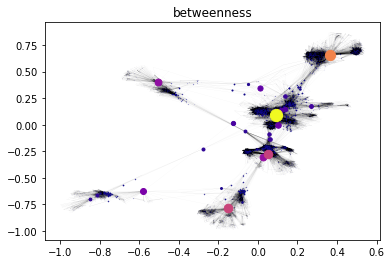

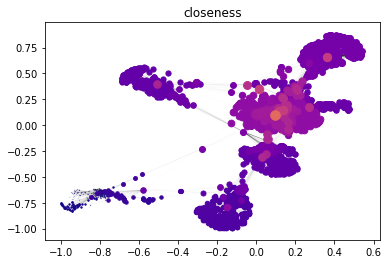

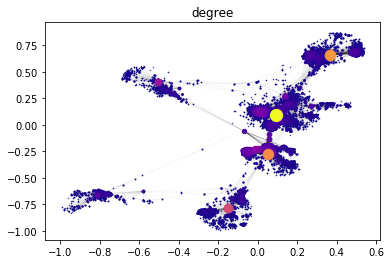

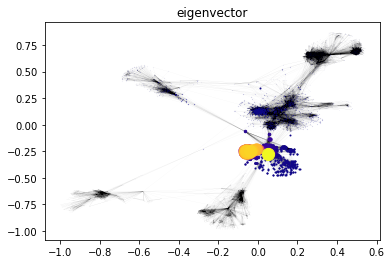

In [28]:
measure='degree'

def draw_measure_graph(measure):
    plt.figure()
    measure_std=(FB_centrality_df[measure] - min(FB_centrality_df[measure]))/max(FB_centrality_df[measure])
    nx.draw_networkx(G_facebook,pos=fb_spring_layout,
                          width=0.1,alpha=0.1,nodelist=[],
                          with_labels=False)

    idx=numpy.argsort(FB_centrality_df[measure])
    for i in idx:
        nx.draw_networkx_nodes(G_facebook,pos=fb_spring_layout,
                               node_size=measure_std[i]*150,
                               cmap='plasma',
                               node_color=measure_std[i],vmin=0,vmax=1,
                               nodelist=[i],labels=None)
    plt.title(measure)

for measure in FB_centrality_df.columns.tolist():
    print('plotting',measure)
    draw_measure_graph(measure)
    


### Simulating a realistic network

Network science has developed a number of theories to explain how complex networks come about.  One of the first models, proposed by Watts & Strogatz (1998), is to start with a ring in which each node is connected to its k nearest neighbors, and then randomly rewire connections with some probability.  The initial ring is highly clustered (since each node is connected to all of its nearest neighbors), but has a long average path length. What they found was that the inclusion of a small number of random rewirings resulted in a substantial reduction of the average path length, while still leaving the network fairly highly clustered.  They termed this a "small world" network.

We can simulate a Watts-Strogatz network using the ```connected_watts_strogatz_graph()``` function in networkx.  This is an enhanced version of the standard Watts-Strogatz simulator, which tries to find a fully connected graph, meaning that all nodes are connected to all other nodes.  We use this because it's not possible to compute average path length in a network that isn't connected, because the path between nodes in different components of the graph will be nonexistent (i.e. infinitely long).

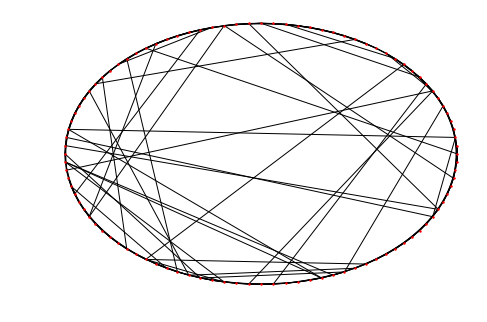

In [29]:
G_ws=nx.watts_strogatz_graph(100,6,0.1)
nx.draw_circular(G_ws,node_size=2)

In [30]:
nx.average_clustering(G_ws)

0.4297619047619048

In [31]:
nx.average_shortest_path_length(G_ws)

3.593131313131313

Watts and Strogatz famously showed that there is a range of rewiring probabilities for which the clustering coefficient remains high but the average path length decreases.  Let's simulate this and see for ourselves.

In [32]:
nnodes=100
nruns=20 # number of simulations to run at each value
kconn=10
rewiring_probs=numpy.hstack((numpy.arange(.0001,0.001,.0001),
                             numpy.arange(.001,0.01,.001),
                             numpy.arange(.01,0.1,.01),
                             numpy.arange(.1,1,.1)))


cc=numpy.zeros(len(rewiring_probs))
apl=numpy.zeros(len(rewiring_probs))

for i,p in enumerate(rewiring_probs.tolist()):
    cc_tmp=numpy.zeros(nruns)
    apl_tmp=numpy.zeros(nruns)
    for r in range(nruns):
        G_tmp=nx.connected_watts_strogatz_graph(nnodes,kconn,p)
        cc_tmp[r]=nx.average_clustering(G_tmp)
        apl_tmp[r]=nx.average_shortest_path_length(G_tmp)
    cc[i]=numpy.mean(cc_tmp)
    apl[i]=numpy.mean(apl_tmp)

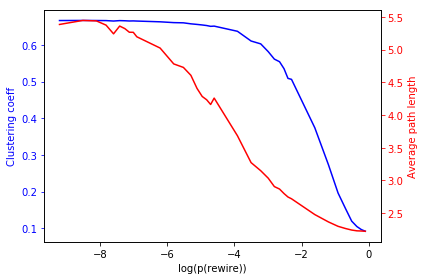

In [33]:
#plt.plot(numpy.log(rewiring_probs),cc)
#plt.plot(numpy.log(rewiring_probs),apl,'r')

fig, ax1 = plt.subplots()
ax1.plot(numpy.log(rewiring_probs),cc, 'b-')
ax1.set_xlabel('log(p(rewire))')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Clustering coeff', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(numpy.log(rewiring_probs),apl, 'r-')
ax2.set_ylabel('Average path length', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()


This plot recapitulates the result from Watts & Strogatz (1998), showing that there is a range of rewiring probabilities where the average path length is relatively short but the network is also nearly as clustered as the ring graph, which they refer to as "small world" networks.